YAMNet Feature Extraction

Extract 1024-dimensional embeddings from preprocessed audio frames
using the pre-trained YAMNet model as a frozen feature extractor.

In [13]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [14]:
PROCESSED_DIR = '../data/processed'
METADATA_PATH = os.path.join(PROCESSED_DIR, 'processed_frames_metadata.csv')
FEATURES_DIR = '../data/approach1/features'
YAMNET_MODEL_URL = 'https://tfhub.dev/google/yamnet/1'
TARGET_SR = 16000
BATCH_SIZE = 32
RANDOM_SEED = 42

# Create output directory
os.makedirs(FEATURES_DIR, exist_ok=True)

# Set seeds for reproducibility
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")



TensorFlow version: 2.15.0
GPU available: False


In [15]:
print("\nLOADING YAMNET MODEL")

try:
    print(f"\nDownloading YAMNet from TensorFlow Hub...")
    print(f"URL: {YAMNET_MODEL_URL}")
    yamnet_model = hub.load(YAMNET_MODEL_URL)
    print("YAMNet model loaded successfully")
    
    # Test the model
    test_audio = np.random.randn(15360).astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(test_audio)
    
    print(f"\nModel verification:")
    print(f"  Input shape: (15360,) - 0.96s at 16kHz")
    print(f"  Output embedding shape: {embeddings.shape} Expected shape: (1, 1024)")
    print(f"  Embedding dimension: {embeddings.shape[1]}")
    
except Exception as e:
    print(f"Error loading YAMNet: {e}")
    raise



LOADING YAMNET MODEL

URL: https://tfhub.dev/google/yamnet/1
YAMNet model loaded successfully

Model verification:
  Input shape: (15360,) - 0.96s at 16kHz
  Output embedding shape: (1, 1024) Expected shape: (1, 1024)
  Embedding dimension: 1024


In [16]:
# LOAD DATASET METADATA
print("\nLOADING DATASET")


df = pd.read_csv(METADATA_PATH)
print(f"\nLoaded metadata: {len(df):,} frames")
print(f"  Categories: {df['category'].nunique()}")
print(f"  Sample rate: {TARGET_SR} Hz")
print(f"  Frame duration: 0.96 seconds")

print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*40)
for cat, count in df['category'].value_counts().sort_index().items():
    percentage = count / len(df) * 100
    print(f"{cat:<20} {count:<10} {percentage:>6.2f}%")



LOADING DATASET

Loaded metadata: 7,100 frames
  Categories: 5
  Sample rate: 16000 Hz
  Frame duration: 0.96 seconds

Category             Count      Percentage
----------------------------------------
Alarm_Clock          1296        18.25%
Car_Horn             1480        20.85%
Glass_Breaking       1216        17.13%
Gunshot              1536        21.63%
Siren                1572        22.14%


In [17]:
# FEATURE EXTRACTION FUNCTION
def extract_yamnet_features(audio_array):
    """
    Extract YAMNet embeddings from audio array.
    
    Args:
        audio_array: numpy array of shape (15360,) with audio at 16kHz
        
    Returns:
        embedding: numpy array of shape (1024,) - averaged embeddings
    """
    # Ensure correct dtype
    if audio_array.dtype != np.float32:
        audio_array = audio_array.astype(np.float32)
    
    # Run inference
    scores, embeddings, spectrogram = yamnet_model(audio_array)
    
    # Average embeddings across frames (typically 1 frame for 0.96s audio)
    embedding = np.mean(embeddings.numpy(), axis=0)
    
    return embedding




In [18]:
# BATCH FEATURE EXTRACTION
print("\nEXTRACTING FEATURES")

features_list = []
labels_list = []
metadata_list = []
failed_files = []

print(f"\nProcessing {len(df):,} audio frames...")

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
    try:
        # Load audio frame
        audio = np.load(row['frame_path'])
        
        # Validate audio
        if len(audio) != 15360:
            raise ValueError(f"Invalid audio length: {len(audio)}, expected 15360")
        
        # Extract features
        embedding = extract_yamnet_features(audio)
        
        # Store results
        features_list.append(embedding)
        labels_list.append(row['category'])
        metadata_list.append({
            'category': row['category'],
            'original_file': row['original_file'],
            'frame_idx': row['frame_idx'],
            'aug_idx': row['aug_idx'],
            'is_augmented': row['is_augmented'],
            'frame_path': row['frame_path']
        })
        
    except Exception as e:
        failed_files.append({
            'file': row['frame_path'],
            'error': str(e)
        })
        print(f"\nFailed: {os.path.basename(row['frame_path'])} - {e}")

# Convert to arrays
X = np.array(features_list)
y = np.array(labels_list)


print("\nEXTRACTION SUMMARY: ")
print(f"Total features extracted: {len(X):,}")
print(f"  Feature shape: {X.shape}")
print(f"  Feature dimension: {X.shape[1]}")
print(f"  Success rate: {len(X)/len(df)*100:.2f}%")
print(f"Failed extractions: {len(failed_files)}")

if failed_files:
    print("\nFailed files (showing first 10):")
    for fail in failed_files[:10]:
        print(f"  - {os.path.basename(fail['file'])}: {fail['error']}")




EXTRACTING FEATURES

Processing 7,100 audio frames...


Extracting features: 100%|██████████| 7100/7100 [02:37<00:00, 44.97it/s]


EXTRACTION SUMMARY: 
Total features extracted: 7,100
  Feature shape: (7100, 1024)
  Feature dimension: 1024
  Success rate: 100.00%
Failed extractions: 0


In [19]:
print("\nSAVING FEATURES")

features_path = os.path.join(FEATURES_DIR, 'yamnet_features.npy')
labels_path = os.path.join(FEATURES_DIR, 'yamnet_labels.npy')
metadata_df_path = os.path.join(FEATURES_DIR, 'yamnet_features_metadata.csv')

np.save(features_path, X)
np.save(labels_path, y)
pd.DataFrame(metadata_list).to_csv(metadata_df_path, index=False)

print(f"\nFeatures saved to:")
print(f"  - Features: {features_path}")
print(f"  - Labels: {labels_path}")
print(f"  - Metadata: {metadata_df_path}")




SAVING FEATURES

Features saved to:
  - Features: ../data/approach1/features\yamnet_features.npy
  - Labels: ../data/approach1/features\yamnet_labels.npy
  - Metadata: ../data/approach1/features\yamnet_features_metadata.csv


In [20]:
# FEATURE STATISTICS

print(f"\nGlobal Statistics:")
print(f"  Mean: {X.mean():.6f}")
print(f"  Std:  {X.std():.6f}")
print(f"  Min:  {X.min():.6f}")
print(f"  Max:  {X.max():.6f}")

# Check for invalid values
nan_count = np.isnan(X).sum()
inf_count = np.isinf(X).sum()
print(f"\nData Quality:")
print(f"  NaN values: {nan_count}")
print(f"  Inf values: {inf_count}")
if nan_count == 0 and inf_count == 0:
    print("     No invalid values detected")
else:
    print("     Warning: Invalid values detected!")

# Per-class statistics
print(f"\n{'Category':<20} {'Samples':<10} {'Mean':<12} {'Std':<12} {'Range'}")
print("-"*80)
for category in sorted(np.unique(y)):
    cat_features = X[y == category]
    print(f"{category:<20} {len(cat_features):<10} {cat_features.mean():>10.6f}  "
          f"{cat_features.std():>10.6f}  [{cat_features.min():.4f}, {cat_features.max():.4f}]")




Global Statistics:
  Mean: 0.072910
  Std:  0.367333
  Min:  0.000000
  Max:  12.627965

Data Quality:
  NaN values: 0
  Inf values: 0
     No invalid values detected

Category             Samples    Mean         Std          Range
--------------------------------------------------------------------------------
Alarm_Clock          1296         0.072726    0.390910  [0.0000, 8.7139]
Car_Horn             1480         0.081500    0.381784  [0.0000, 12.2793]
Glass_Breaking       1216         0.056515    0.353732  [0.0000, 12.6280]
Gunshot              1536         0.064806    0.337953  [0.0000, 10.1144]
Siren                1572         0.085575    0.370587  [0.0000, 7.5709]



Computing PCA (1024 → 2 dimensions)...
PCA complete
  PC1 variance explained: 18.26%
  PC2 variance explained: 12.00%
  Total variance explained: 30.25%
  Saved: ../data/approach1/features\pca_visualization.png


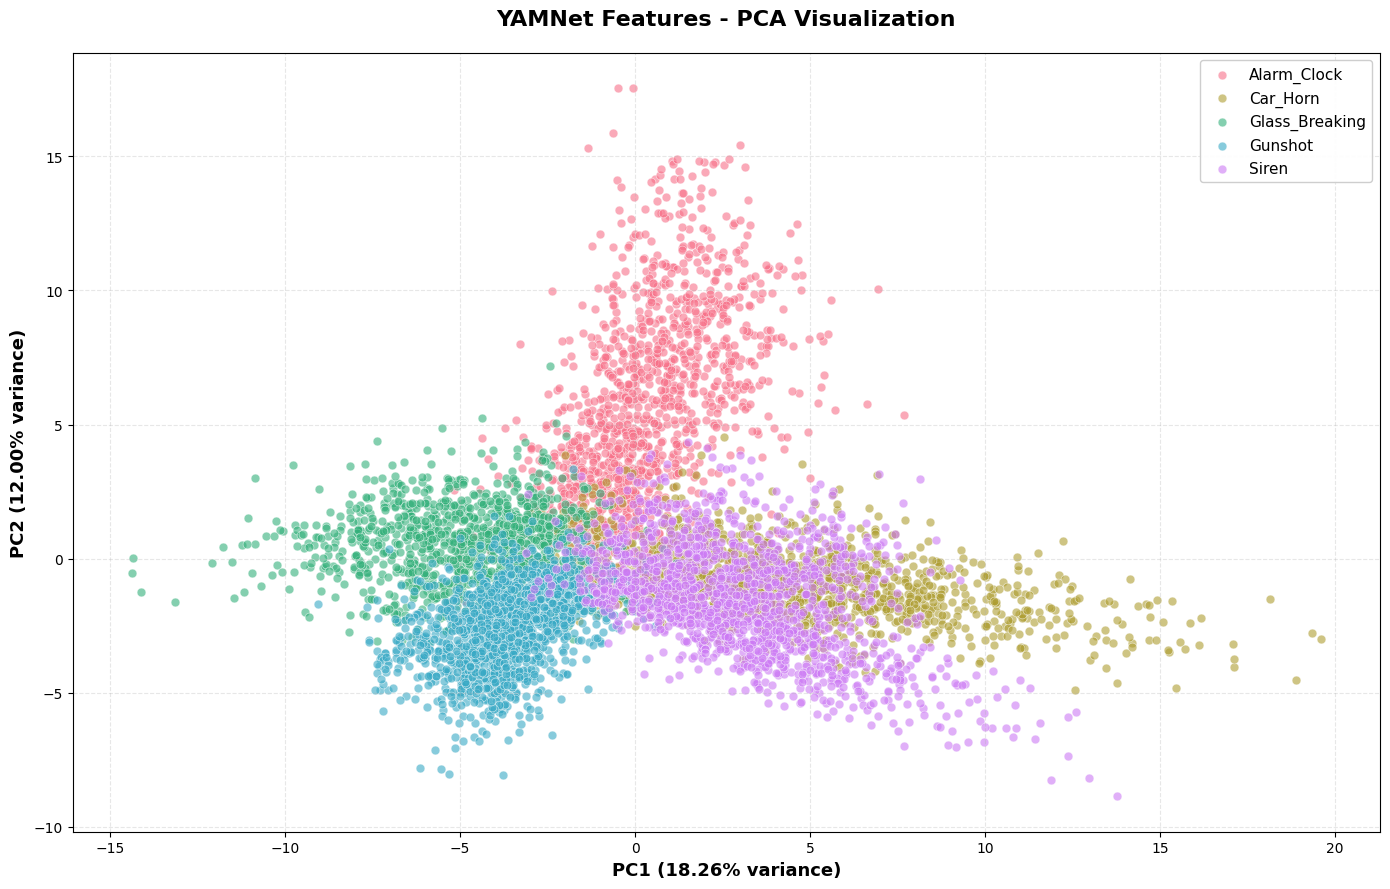

In [21]:
# DIMENSIONALITY REDUCTION - PCA (Visualization Purposes Only)
print("\nComputing PCA (1024 → 2 dimensions)...")
pca = PCA(n_components=2, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X)

print(f"PCA complete")
print(f"  PC1 variance explained: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  PC2 variance explained: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Plot PCA
plt.figure(figsize=(14, 9))
categories = sorted(np.unique(y))
colors = sns.color_palette("husl", len(categories))

for idx, category in enumerate(categories):
    mask = y == category
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                c=[colors[idx]], label=category, alpha=0.6, s=40, edgecolors='w', linewidth=0.5)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=13, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=13, fontweight='bold')
plt.title('YAMNet Features - PCA Visualization', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', framealpha=0.95, fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
pca_path = os.path.join(FEATURES_DIR, 'pca_visualization.png')
plt.savefig(pca_path, dpi=300, bbox_inches='tight')
print(f"  Saved: {pca_path}")
plt.show()


DIMENSIONALITY REDUCTION - t-SNE

Computing t-SNE on 5,000 samples...
This may take a few minutes...
t-SNE complete
  Saved: ../data/approach1/features\tsne_visualization.png


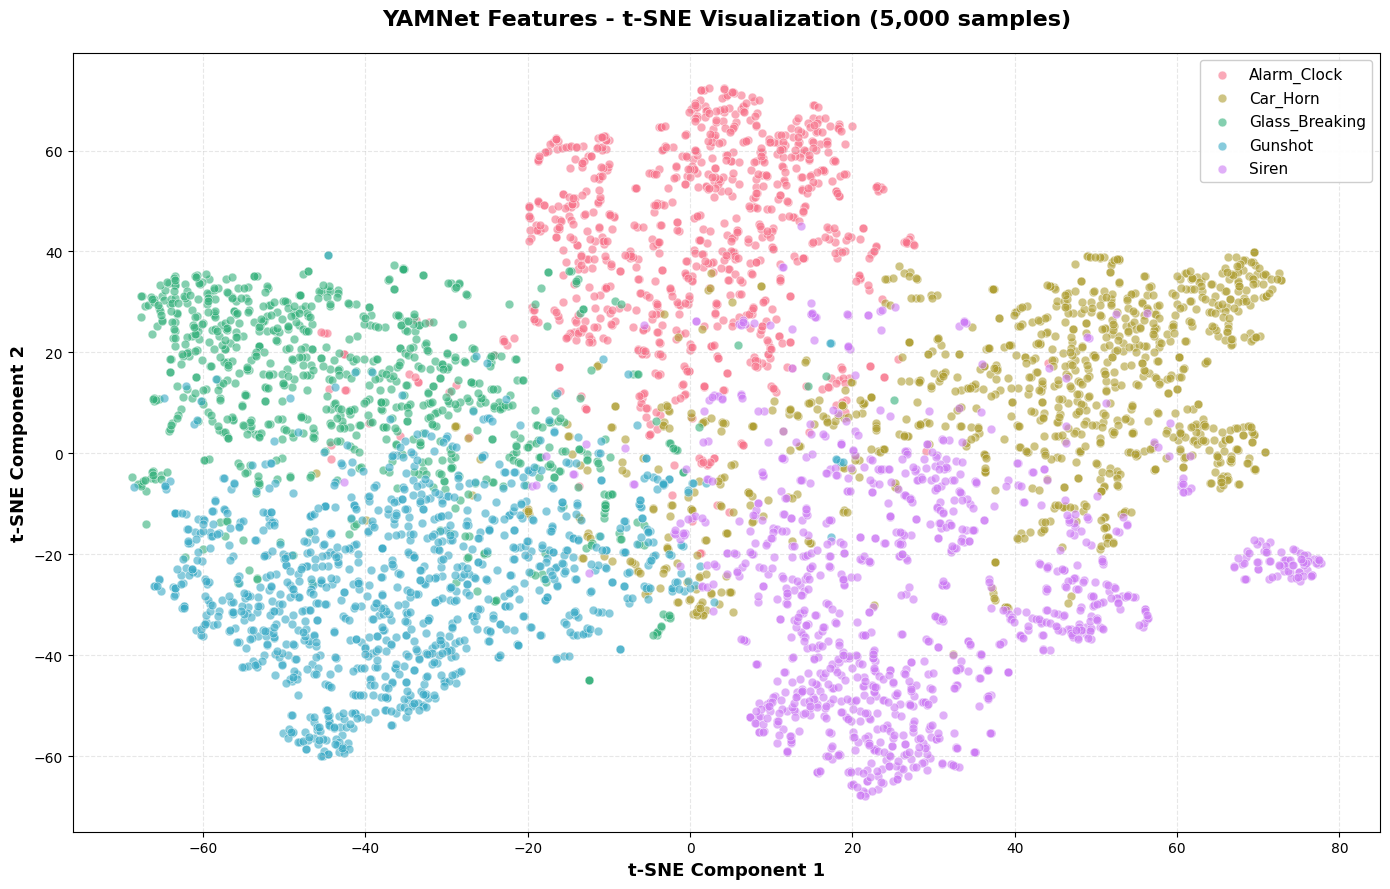

In [22]:
# DIMENSIONALITY REDUCTION - t-SNE (Visualization Purposes only)

print("DIMENSIONALITY REDUCTION - t-SNE")

# Use subset for t-SNE (computational efficiency)
subset_size = min(5000, len(X))
indices = np.random.choice(len(X), subset_size, replace=False)
X_subset = X[indices]
y_subset = y[indices]

print(f"\nComputing t-SNE on {subset_size:,} samples...")
print("This may take a few minutes...")
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, 
            perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_subset)
print("t-SNE complete")

# Plot t-SNE
plt.figure(figsize=(14, 9))
for idx, category in enumerate(categories):
    mask = y_subset == category
    plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                c=[colors[idx]], label=category, alpha=0.6, s=40, edgecolors='w', linewidth=0.5)

plt.xlabel('t-SNE Component 1', fontsize=13, fontweight='bold')
plt.ylabel('t-SNE Component 2', fontsize=13, fontweight='bold')
plt.title(f'YAMNet Features - t-SNE Visualization ({subset_size:,} samples)',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='best', framealpha=0.95, fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
tsne_path = os.path.join(FEATURES_DIR, 'tsne_visualization.png')
plt.savefig(tsne_path, dpi=300, bbox_inches='tight')
print(f"  Saved: {tsne_path}")
plt.show()



Feature variability:
  Total features: 1024
  Variable features: 718 (70.1%)
  Constant/near-constant: 306

Computing correlation matrix for 50 features...
  Saved: ../data/approach1/features\correlation_matrix.png


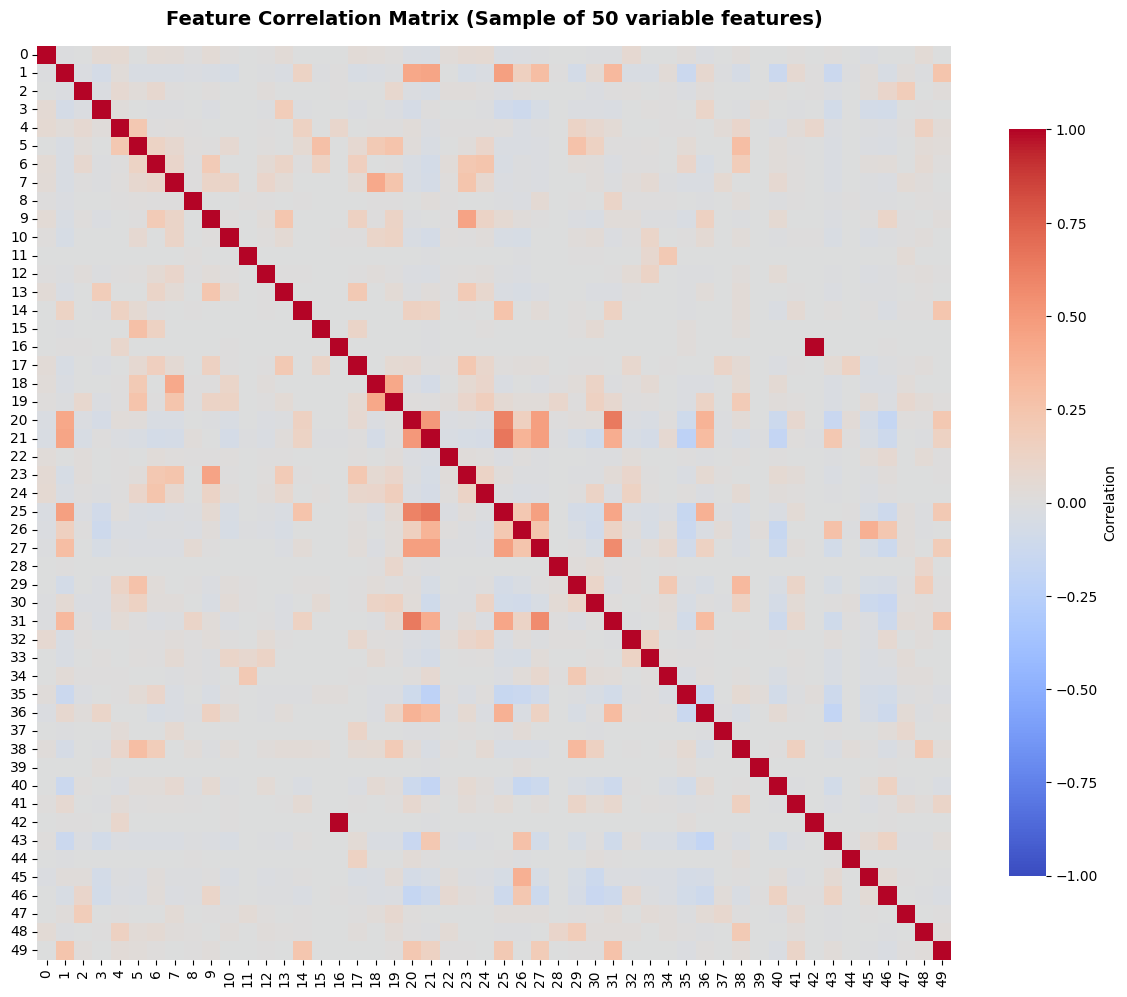


Correlation statistics (excluding diagonal):
  Mean:     0.0193
  Median:  -0.0009
  Std:      0.0877
  Min:     -0.2141
  Max:      1.0000

  1 feature pairs with |correlation| > 0.9


In [23]:
# FEATURE CORRELATION ANALYSIS

# Identify non-constant features
feature_stds = X.std(axis=0)
non_constant_features = np.where(feature_stds > 1e-6)[0]

print(f"\nFeature variability:")
print(f"  Total features: {X.shape[1]}")
print(f"  Variable features: {len(non_constant_features)} ({len(non_constant_features)/X.shape[1]*100:.1f}%)")
print(f"  Constant/near-constant: {X.shape[1] - len(non_constant_features)}")

if len(non_constant_features) >= 10:
    # Sample features for correlation matrix
    n_features_to_plot = min(50, len(non_constant_features))
    if len(non_constant_features) > n_features_to_plot:
        random_features = np.random.choice(non_constant_features, 
                                          n_features_to_plot, replace=False)
    else:
        random_features = non_constant_features
    
    X_sample = X[:, random_features]
    
    # Compute correlation matrix
    print(f"\nComputing correlation matrix for {len(random_features)} features...")
    corr_matrix = np.corrcoef(X_sample.T)
    
    # Plot correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True,
                linewidths=0, cbar_kws={"shrink": 0.8, "label": "Correlation"},
                vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Matrix (Sample of {len(random_features)} variable features)',
              fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    corr_path = os.path.join(FEATURES_DIR, 'correlation_matrix.png')
    plt.savefig(corr_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {corr_path}")
    plt.show()
    
    # Correlation statistics
    if corr_matrix.shape[0] > 1:
        upper_triangle = corr_matrix[np.triu_indices_from(corr_matrix, k=1)]
        if len(upper_triangle) > 0:
            print(f"\nCorrelation statistics (excluding diagonal):")
            print(f"  Mean:   {np.mean(upper_triangle):>8.4f}")
            print(f"  Median: {np.median(upper_triangle):>8.4f}")
            print(f"  Std:    {np.std(upper_triangle):>8.4f}")
            print(f"  Min:    {np.min(upper_triangle):>8.4f}")
            print(f"  Max:    {np.max(upper_triangle):>8.4f}")
            
            # Check for highly correlated features
            high_corr = np.sum(np.abs(upper_triangle) > 0.9)
            if high_corr > 0:
                print(f"\n  {high_corr} feature pairs with |correlation| > 0.9")
            else:
                print(f"\n  No extremely high correlations detected")
else:
    print("\nToo few variable features for correlation analysis")


In [24]:
# FINAL SUMMARY
print(f"\nSuccessfully extracted features for {len(X)} samples")
print(f"Feature dimension: {X.shape[1]}")
print(f"Classes: {len(categories)}")
print(f"Files saved to: {FEATURES_DIR}")



Successfully extracted features for 7100 samples
Feature dimension: 1024
Classes: 5
Files saved to: ../data/approach1/features
